# <center>  LAB10 - Równania rózniczkowe, spectral bias </center>
# <center>  Gosztyła Mikołaj, Smółka Antoni </center> 

## Zadanie 1
Dane jest równanie różniczkowe zwyczajne

$$ \frac{du(x)}{dx} = \cos(\omega x) \text{ dla } x \in \Omega , $$

gdzie:
- $ x, \omega, u \in \mathbb{R} $,
- $ x $ to położenie,
- $ \Omega $ to dziedzina, na której rozwiązujemy równanie, $ \Omega = \{ x \mid -2\pi \leq x \leq 2\pi \} $,
- $ u(\cdot) $ to funkcja, której postaci szukamy.

Warunek początkowy zdefiniowany jest następująco:

$$ u(0) = 0 . $$

Analityczna postać rozwiązania równania $(1)$ z warunkiem początkowym $(2)$ jest następująca:

$$ u(x) = \frac{1}{\omega} \sin(\omega x) . $$

Rozwiąż powyższe zagadnienie początkowe.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(1, 16)
        self.hidden2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.tanh(self.hidden1(x))
        x = self.tanh(self.hidden2(x))
        x = self.output(x)
        return x

def loss_function(u_hat, u_hat_x, cos_omega_x, u_hat_0):
    Lr = torch.mean((u_hat_x - cos_omega_x) ** 2)
    LIC = (u_hat_0 - 0) ** 2
    return Lr + LIC

### (a) Przypadek ω = 1.
Ustal następujące wartości:
- 2 warstwy ukryte, 16 neuronów w każdej warstwie
- liczba punktów treningowych: 200
- liczba punktów testowych: 1000

In [3]:
omega = 1

x_train = np.linspace(-2*np.pi, 2*np.pi, 200).reshape(-1, 1)
x_test = np.linspace(-2*np.pi, 2*np.pi, 1000).reshape(-1, 1)

x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
x_test = torch.tensor(x_test, dtype=torch.float32)
cos_omega_x_train = torch.cos(omega * x_train)
cos_omega_x_test = torch.cos(omega * x_test)

# Inicjalizacja modelu i optymalizatora
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trenowanie modelu
num_epochs = 50000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    u_hat = model(x_train)
    u_hat_x = torch.autograd.grad(u_hat, x_train, torch.ones_like(u_hat), create_graph=True)[0]
    u_hat_0 = model(torch.tensor([[0.0]], dtype=torch.float32))
    
    loss = loss_function(u_hat, u_hat_x, cos_omega_x_train, u_hat_0)
    loss.backward(retain_graph=True)  # Dodanie retain_graph=True
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.6090518832206726
Epoch 1000, Loss: 0.016231270506978035
Epoch 2000, Loss: 9.318569209426641e-05
Epoch 3000, Loss: 3.9160371670732275e-05
Epoch 4000, Loss: 1.9805269403150305e-05
Epoch 5000, Loss: 1.0380405001342297e-05
Epoch 6000, Loss: 6.7546670834417455e-06
Epoch 7000, Loss: 4.1745888665900566e-06
Epoch 8000, Loss: 3.324289991724072e-06
Epoch 9000, Loss: 1.2555611647258047e-05
Epoch 10000, Loss: 1.4918529132046388e-06
Epoch 11000, Loss: 7.356370042543858e-05
Epoch 12000, Loss: 8.572168894716015e-07
Epoch 13000, Loss: 7.12593305252085e-07
Epoch 14000, Loss: 5.897496180296002e-07
Epoch 15000, Loss: 5.189349394640885e-07
Epoch 16000, Loss: 4.697564008893096e-07
Epoch 17000, Loss: 1.65083042702463e-06
Epoch 18000, Loss: 4.063783762831008e-07
Epoch 19000, Loss: 4.093034817742591e-07
Epoch 20000, Loss: 3.6867911035187717e-07
Epoch 21000, Loss: 5.837696789967595e-06
Epoch 22000, Loss: 4.864179118158063e-06
Epoch 23000, Loss: 4.4664892584478366e-07
Epoch 24000, Loss: 3.26957

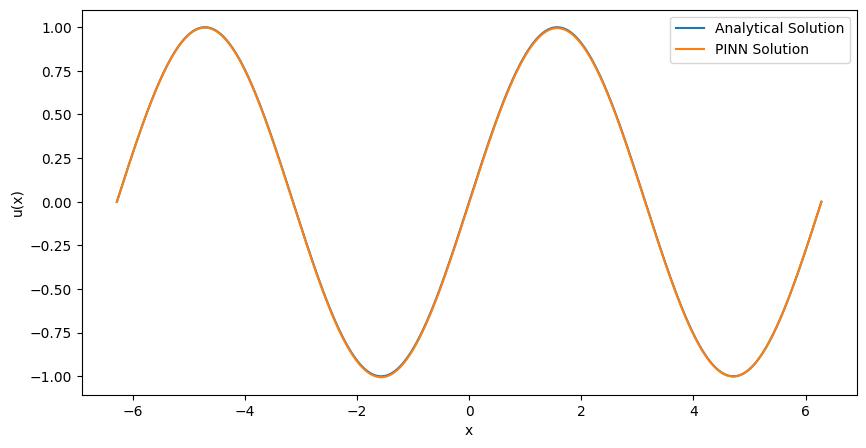

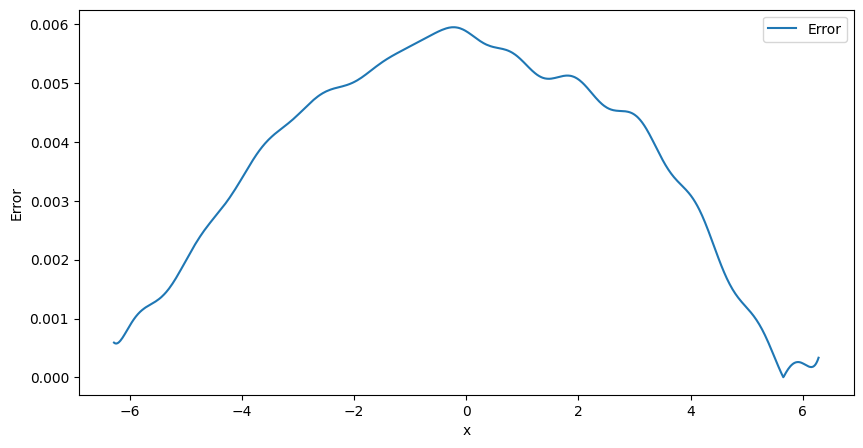

In [4]:
# Predykcje modelu
with torch.no_grad():
    u_pred = model(x_test)
    u_true = (1/omega) * np.sin(omega * x_test.numpy())

plt.figure(figsize=(10,5))
plt.plot(x_test, u_true, label='Analytical Solution')
plt.plot(x_test, u_pred.numpy(), label='PINN Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(x_test, np.abs(u_pred.numpy() - u_true), label='Error')
plt.xlabel('x')
plt.ylabel('Error')
plt.legend()
plt.show()

### (b) Przypadek ω = 15.
Ustal następujące wartości:
- liczba punktów treningowych: 200 * 15 = 3000
- liczba punktów testowych: 5000

Eksperymenty przeprowadź z trzema architekturami sieci:
- 2 warstwy ukryte, 16 neuronów w każdej warstwie
- 4 warstwy ukryte, 64 neurony w każdej warstwie
- 5 warstw ukrytych, 128 neuronów w każdej warstwie

Epoch 0, Loss: 0.5121310949325562
Epoch 1000, Loss: 0.5001651048660278
Epoch 2000, Loss: 0.5001636743545532
Epoch 3000, Loss: 0.5001618266105652
Epoch 4000, Loss: 0.5001600980758667
Epoch 5000, Loss: 0.5001580119132996
Epoch 6000, Loss: 0.5001568794250488
Epoch 7000, Loss: 0.5001550912857056
Epoch 8000, Loss: 0.5001533627510071
Epoch 9000, Loss: 0.5001516342163086
Epoch 10000, Loss: 0.5001498460769653
Epoch 11000, Loss: 0.5001488327980042
Epoch 12000, Loss: 0.500146210193634
Epoch 13000, Loss: 0.5001446604728699
Epoch 14000, Loss: 0.5001431703567505
Epoch 15000, Loss: 0.5001417994499207
Epoch 16000, Loss: 0.5001404285430908
Epoch 17000, Loss: 0.5001463294029236
Epoch 18000, Loss: 0.5001377463340759
Epoch 19000, Loss: 0.5001363158226013
Epoch 20000, Loss: 0.5001349449157715
Epoch 21000, Loss: 0.5001460313796997
Epoch 22000, Loss: 0.5001319050788879
Epoch 23000, Loss: 0.5001304745674133
Epoch 24000, Loss: 0.5001291036605835
Epoch 25000, Loss: 0.5001273155212402
Epoch 26000, Loss: 0.50012

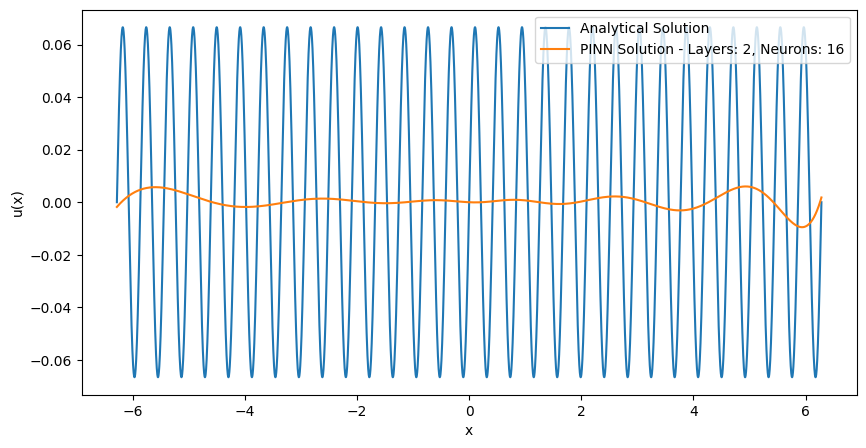

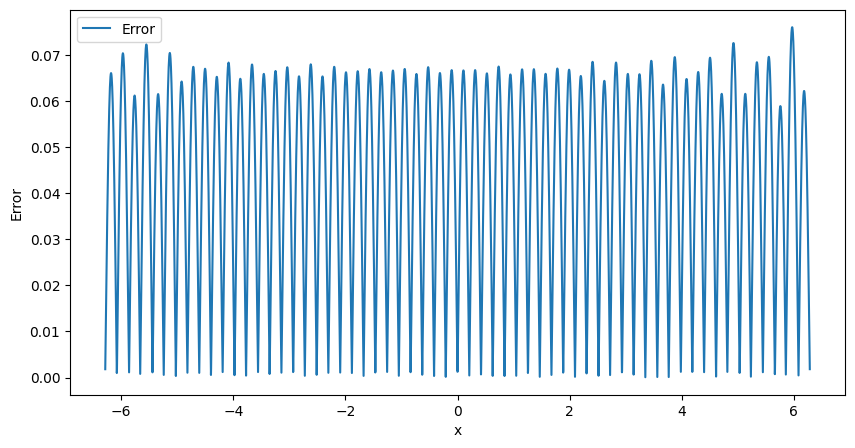

Epoch 0, Loss: 0.5064938068389893
Epoch 1000, Loss: 0.5001600980758667
Epoch 2000, Loss: 0.5001575350761414
Epoch 3000, Loss: 0.5001557469367981
Epoch 4000, Loss: 0.5001542568206787
Epoch 5000, Loss: 0.5001530647277832
Epoch 6000, Loss: 0.5001521110534668
Epoch 7000, Loss: 0.5001615881919861
Epoch 8000, Loss: 0.5001492500305176
Epoch 9000, Loss: 0.5001492500305176
Epoch 10000, Loss: 0.50014728307724
Epoch 11000, Loss: 0.5001471638679504
Epoch 12000, Loss: 0.500146746635437
Epoch 13000, Loss: 0.5001445412635803
Epoch 14000, Loss: 0.5001448392868042
Epoch 15000, Loss: 0.5001429915428162
Epoch 16000, Loss: 0.5001441836357117
Epoch 17000, Loss: 0.5001418590545654
Epoch 18000, Loss: 0.5001423954963684
Epoch 19000, Loss: 0.5001130104064941
Epoch 20000, Loss: 0.38574907183647156
Epoch 21000, Loss: 0.35876548290252686
Epoch 22000, Loss: 0.33144429326057434
Epoch 23000, Loss: 0.3104655146598816
Epoch 24000, Loss: 0.2962793707847595
Epoch 25000, Loss: 0.2864895164966583
Epoch 26000, Loss: 0.2530

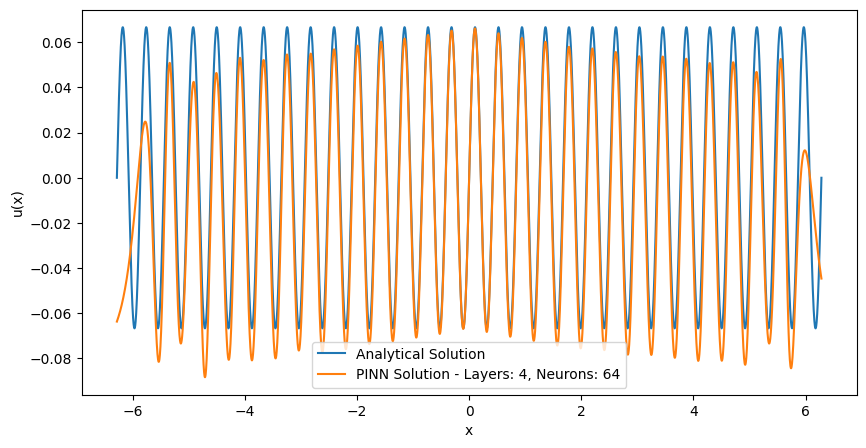

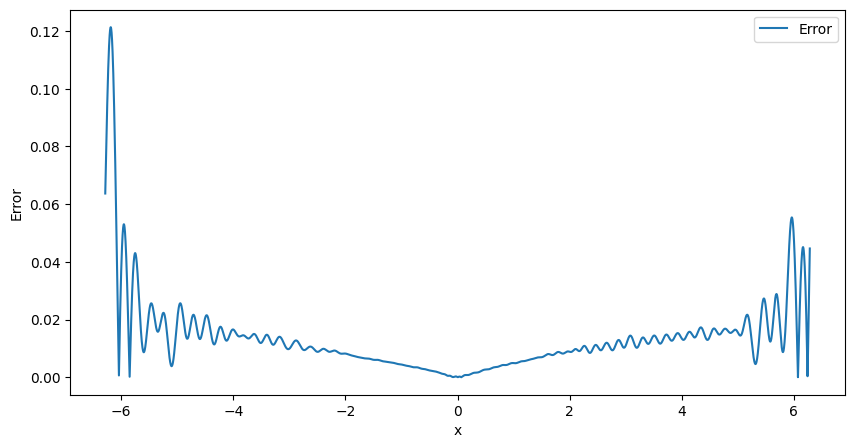

Epoch 0, Loss: 0.528526246547699
Epoch 1000, Loss: 0.500161349773407
Epoch 2000, Loss: 0.5001577734947205
Epoch 3000, Loss: 0.5001553297042847
Epoch 4000, Loss: 0.5001539587974548
Epoch 5000, Loss: 0.5001673102378845
Epoch 6000, Loss: 0.5001704096794128
Epoch 7000, Loss: 0.5001519918441772
Epoch 8000, Loss: 0.5001487731933594
Epoch 9000, Loss: 0.5001476407051086
Epoch 10000, Loss: 0.5001465082168579
Epoch 11000, Loss: 0.5001448392868042
Epoch 12000, Loss: 0.5001429319381714
Epoch 13000, Loss: 0.5005426406860352
Epoch 14000, Loss: 0.49997082352638245
Epoch 15000, Loss: 0.4614681899547577
Epoch 16000, Loss: 0.29915812611579895
Epoch 17000, Loss: 0.22023837268352509
Epoch 18000, Loss: 0.1403391808271408
Epoch 19000, Loss: 0.08351539820432663
Epoch 20000, Loss: 0.058439504355192184
Epoch 21000, Loss: 0.03446479141712189
Epoch 22000, Loss: 0.010175454430282116
Epoch 23000, Loss: 0.00038530465099029243
Epoch 24000, Loss: 0.00017219979781657457
Epoch 25000, Loss: 0.00023460683587472886
Epoch 

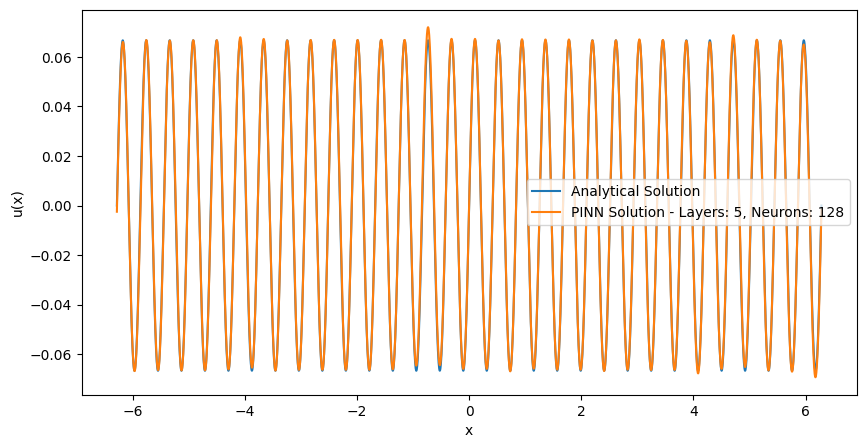

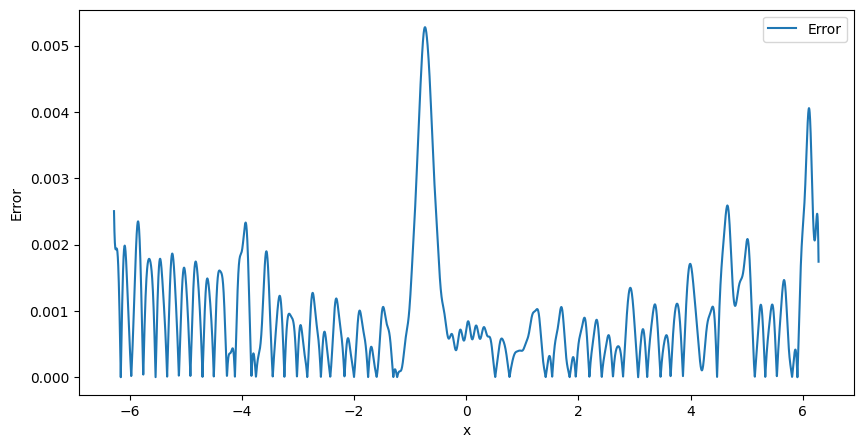

In [5]:
omega = 15
x_train = np.linspace(-2*np.pi, 2*np.pi, 3000).reshape(-1, 1)
x_test = np.linspace(-2*np.pi, 2*np.pi, 5000).reshape(-1, 1)

x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
x_test = torch.tensor(x_test, dtype=torch.float32)
cos_omega_x_train = torch.cos(omega * x_train)
cos_omega_x_test = torch.cos(omega * x_test)

# Definiowanie modeli dla trzech różnych architektur
architectures = [(2, 16), (4, 64), (5, 128)]

for layers, neurons in architectures:
    model = PINN()
    model.hidden1 = nn.Linear(1, neurons)
    model.hidden2 = nn.Linear(neurons, neurons)
    model.output = nn.Linear(neurons, 1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        u_hat = model(x_train)
        u_hat_x = torch.autograd.grad(u_hat, x_train, torch.ones_like(u_hat), create_graph=True)[0]
        u_hat_0 = model(torch.tensor([[0.0]], dtype=torch.float32))
        
        loss = loss_function(u_hat, u_hat_x, cos_omega_x_train, u_hat_0)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

     # Predykcje modelu
    with torch.no_grad():
        u_pred = model(x_test)
        u_true = (1/omega) * np.sin(omega * x_test.numpy())
        
    # Wykres funkcji
    plt.figure(figsize=(10,5))
    plt.plot(x_test, u_true, label='Analytical Solution')
    plt.plot(x_test, u_pred.numpy(), label=f'PINN Solution - Layers: {layers}, Neurons: {neurons}')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    plt.show()
    
    # Wykres błędu
    plt.figure(figsize=(10,5))
    plt.plot(x_test, np.abs(u_pred.numpy() - u_true), label='Error')
    plt.xlabel('x')
    plt.ylabel('Error')
    plt.legend()
    plt.show()